In [1]:
%matplotlib inline
import inspect
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import timeit
import torch
import torch.nn.functional as F
import torch._C._te as te

scope = te.KernelScope()

from utils import *



- would sure be nice to have parallel :)
- the current separation of applying schedules is a little bit wonky and weird

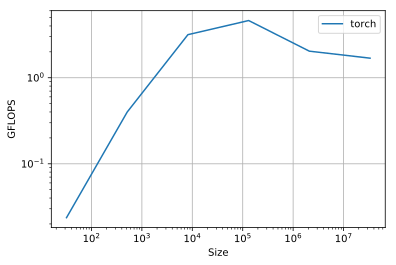

In [2]:
sizes = 2**np.arange(5, 29, 4)
def np_add(n):
    a, b,c = get_abc((n,), torch.tensor)
    return timer_iters(lambda : torch.add(a, b, out=c))
exe_times = [bench_workload(np_add(int(n))) for n in sizes]
np_gflops = sizes / 1e9 / np.array(exe_times)
plot_gflops(sizes, [np_gflops], ['torch'])

In [3]:
def bench_vector_add_tvm(func, sizes):
    def workload(nrepeats):
        time = timeit.timeit(lambda: mod(a,b,c), number=nrepeats)
        return time
    times = []
    for n in sizes:
        s, (A, B, C) = func(int(n))
        s.prepare_for_codegen()
        mod = te_codegen('llvm', s.simplify(), [A, B, C])
        a, b, c = get_abc((n,), torch.tensor)
        times.append(bench_workload(workload))
    return sizes / 1e9 / np.array(times)

In [4]:
def vector_add(n):
    A = te_placeholder(name='a', shape=(n,))
    B = te_placeholder(name='b', shape=(n,))
    C = te.Compute('c', get_dim_args((n,)), lambda i: A.load([i]) + B.load([i]))
    return A, B, C

def default(n):
    A, B, C = vector_add(n)
    s = te.LoopNest([C])
    return s, (A, B, C)


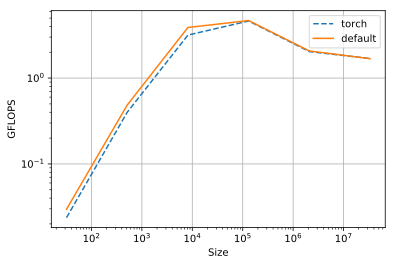

In [5]:
default_gflops = bench_vector_add_tvm(default, sizes)
plot_gflops(sizes, [np_gflops, default_gflops], ['torch', 'default'])